In [149]:
import os
import pathlib
import time

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from PIL import Image
import requests
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tf_keras_vis.utils import normalize
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [2]:
working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)


In [3]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

print(f"tensorflow version {tf.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.15.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Available GPUs: 
[]



In [ ]:
# load datasets and preview training data
test_dataset = tf.data.Dataset.load('tf_data/test_data')
train_dataset = tf.data.Dataset.load('tf_data/train_data')
val_dataset = tf.data.Dataset.load('tf_data/validation_data')


### Error analysis for baseline model

In [6]:
# Preprocessing
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def preprocess(img, label):
    return normalize_image(img), label

train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
# Construct baseline model
baseline_model = Sequential([
    # First convolutional layer with 80 filters
    Conv2D(80, kernel_size=(128, 6), padding='same', input_shape=(128, 431, 1)),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(4, 6)),

    # Second convolutional layer with 160 filters
    Conv2D(160, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(1, 2)),

    # Continue the pattern...
    Conv2D(240, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    Conv2D(320, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    # Flatten the output of the conv layers to connect it with dense layers
    Flatten(),

    # Dropout layer
    Dropout(0.5),

    # Output layer with softmax activation
    Dense(10, activation='softmax', kernel_regularizer=L2(0.001))
])

In [8]:
# Load stored weights
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
baseline_model.load_weights('models/baseline.h5')

In [9]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 431, 80)      61520     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 431, 80)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 71, 80)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 71, 160)       25760     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 71, 160)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 35, 160)       0         
 g2D)                                                   

In [12]:
# Predict on test dataset
test_pred = baseline_model.predict(test_dataset)

720/720 [==============================] - 556s 771ms/step


In [54]:
# grab labels for test items
test_labels = []
for images, labels in test_dataset.unbatch():
    test_labels.append(labels)

In [55]:
# true and predicted classes for test items
pred_classes_test = [np.argmax(x) for x in test_pred]

true_classes_test = [np.argmax(x) for x in test_labels]

In [123]:
# Label classes by species name
with open('tf_data/species_encoding.pkl', 'rb') as f:
    birdnames = pickle.load(f)
birdnames_back = {val: key for key, val in birdnames.items()}

In [50]:
confusion_matrix(true_classes_test, pred_classes_test)

array([[3589,   96,   68,   76,   71,   47,    9,   32,    5,   21],
       [ 209, 2670,  275,  135,  165,   53,   63,   69,    1,   34],
       [  81,   68, 2446,   56,  111,   24,   29,   46,   15,   13],
       [  48,   17,   97, 1817,  156,   34,   36,   49,    3,    4],
       [  13,    8,   73,   45, 2051,   13,   15,   15,    4,   11],
       [  32,   19,   15,   11,   54, 1956,    5,    2,    1,    0],
       [  57,   23,   95,   98,  209,   49, 1047,   65,   18,   26],
       [  30,   21,   45,   98,   59,   34,   41, 1341,   10,    4],
       [  32,   14,  127,   38,  226,   23,   20,   21, 1103,    3],
       [  29,   22,   53,   18,   94,   15,   12,   21,    1,  603]])

In [96]:
# report classification accuracy scores
print("Baseline model classification accuracy report")
print(classification_report(true_classes_test, pred_classes_test))

Baseline model classification accuracy report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4014
           1       0.90      0.73      0.81      3674
           2       0.74      0.85      0.79      2889
           3       0.76      0.80      0.78      2261
           4       0.64      0.91      0.75      2248
           5       0.87      0.93      0.90      2095
           6       0.82      0.62      0.71      1687
           7       0.81      0.80      0.80      1683
           8       0.95      0.69      0.80      1607
           9       0.84      0.69      0.76       868

    accuracy                           0.81     23026
   macro avg       0.82      0.79      0.80     23026
weighted avg       0.82      0.81      0.81     23026



### Error analysis for additional features model

In [97]:
# Load datasets
test_dataset = tf.data.Dataset.load('tf_data_additional/test_data')
train_dataset = tf.data.Dataset.load('tf_data_additional/train_data')
val_dataset = tf.data.Dataset.load('tf_data_additional/validation_data')

In [100]:
# Preprocessing
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def preprocess(img, label):
    return {'image_input': normalize_image(img['image_input']), 'feature_input': img['feature_input']}, label

print(train_dataset.take(1))

train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

<_TakeDataset element_spec=({'image_input': TensorSpec(shape=(128, 431), dtype=tf.uint8, name=None), 'feature_input': TensorSpec(shape=(5,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float32, name=None))>


In [101]:
# Make model with additional features
input_img = tf.keras.Input((128, 431, 1), name='image_input')
first_conv = Conv2D(80, kernel_size=(125, 6), padding='same')(input_img)
first_rlu = LeakyReLU(alpha=0.3)(first_conv)
first_pool = MaxPooling2D(pool_size=(4, 6))(first_rlu)
second_conv = Conv2D(160, kernel_size=(1, 2), padding='same')(first_pool)
second_rlu = LeakyReLU(alpha=0.3)(second_conv)
second_pool = MaxPooling2D(pool_size=(1, 2))(second_rlu)
third_conv = Conv2D(240, kernel_size=(1, 2), padding='same')(second_pool)
third_rlu = LeakyReLU(alpha=0.3)(third_conv)
third_pool =  MaxPooling2D(pool_size=(1, 2))(third_rlu)
fourth_conv = Conv2D(320, kernel_size=(1, 2), padding='same')(third_pool)
fourth_rlu = LeakyReLU(alpha=0.3)(fourth_conv)
fourth_pool =  MaxPooling2D(pool_size=(1, 2))(fourth_rlu)
flatten = Flatten()(fourth_pool)
dropout = Dropout(0.5)(flatten)
input_features = tf.keras.Input(5, name='feature_input')
dense3 = Dense(100, activation='relu')(input_features)
dense6 = Dense(100, activation='relu')(dense3)
dropout3 = Dropout(0.5)(dense6)
dense4 = Dense(100, activation='relu')(dropout3)
dense5 = Dense(100, activation='relu')(dense4)
dropout4 = Dropout(0.5)(dense5)
concat = tf.keras.layers.Concatenate()([dropout, dropout4])
output= Dense(10, activation='softmax', kernel_regularizer=L2(0.001))(concat)






additional_features = Model(inputs =[input_img, input_features], outputs=output)

additional_features.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 128, 431, 1)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 128, 431, 80)         60080     ['image_input[0][0]']         
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 431, 80)         0         ['conv2d_4[0][0]']            
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 32, 71, 80)           0         ['leaky_re_lu_4[0][0]']       
 g2D)                                                                                         

In [103]:
# Load previously trained weights
additional_features.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
additional_features.load_weights('models/other_features.h5')

In [104]:
# Predict labels for test data
additional_model_pred = additional_features.predict(test_dataset)

720/720 [==============================] - 569s 790ms/step


In [ ]:
# grab labels for test items
test_labels = []
for images, labels in test_dataset.unbatch():
    test_labels.append(labels)
true_classes_test = [np.argmax(x) for x in test_labels]

In [105]:
# Confusion matrix
pred_classes_add_test = [np.argmax(x) for x in additional_model_pred]
confusion_matrix(true_classes_test, pred_classes_add_test)

array([[3666,  114,   66,   52,   44,   22,    7,   20,   11,   12],
       [ 200, 2898,  203,   97,  111,   28,   62,   56,    5,   14],
       [  63,   88, 2438,   46,  107,    8,   19,   91,   18,   11],
       [  50,   23,   46, 1899,  131,   17,   28,   57,    7,    3],
       [  17,   17,   63,   54, 2042,    3,   15,   17,   10,   10],
       [  46,   17,    3,   30,   56, 1928,    3,    7,    3,    2],
       [  51,   38,   72,  122,  175,   23, 1127,   42,   26,   11],
       [  34,   23,   31,   82,   44,   16,   23, 1418,   10,    2],
       [  30,    7,   74,   40,  109,   15,   12,   20, 1296,    4],
       [  35,   19,   23,   38,   66,   12,   16,   23,    6,  630]])

In [108]:
# report classification accuracy scores
print("Additional features model classification accuracy report")
print(classification_report(true_classes_test, pred_classes_add_test))

Additional features model classification accuracy report
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4014
           1       0.89      0.79      0.84      3674
           2       0.81      0.84      0.83      2889
           3       0.77      0.84      0.80      2261
           4       0.71      0.91      0.80      2248
           5       0.93      0.92      0.93      2095
           6       0.86      0.67      0.75      1687
           7       0.81      0.84      0.83      1683
           8       0.93      0.81      0.86      1607
           9       0.90      0.73      0.80       868

    accuracy                           0.84     23026
   macro avg       0.85      0.83      0.83     23026
weighted avg       0.85      0.84      0.84     23026



### Smaller kernel model error analysis

In [109]:
# Load datasets and preprocess
test_dataset = tf.data.Dataset.load('tf_data/test_data')
train_dataset = tf.data.Dataset.load('tf_data/train_data')
val_dataset = tf.data.Dataset.load('tf_data/validation_data')

def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def preprocess(img, label):
    return normalize_image(img), label

train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [110]:
# Build smaller kernel model
smaller_kernel = Sequential([
    # First convolutional layer with 80 filters
    Conv2D(80, kernel_size=(125, 6), padding='same', input_shape=(128, 431, 1)),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(4, 6)),

    # Second convolutional layer with 160 filters
    Conv2D(160, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(1, 2)),

    # Continue the pattern...
    Conv2D(240, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    Conv2D(320, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    # Flatten the output of the conv layers to connect it with dense layers
    Flatten(),

    # Dropout layer
    Dropout(0.5),

    # Output layer with softmax activation
    Dense(10, activation='softmax', kernel_regularizer=L2(0.001))
])

smaller_kernel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 431, 80)      60080     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128, 431, 80)      0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 32, 71, 80)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 71, 160)       25760     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 71, 160)       0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 32, 35, 160)       0         
 g2D)                                                 

In [111]:
# Load previously trained wights
smaller_kernel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
smaller_kernel.load_weights('models/smaller_kernel.h5')

In [112]:
# predict on test data
smaller_kernel_pred = smaller_kernel.predict(test_dataset)

720/720 [==============================] - 567s 787ms/step


In [126]:
# grab labels for test items
test_labels = []
for images, labels in test_dataset.unbatch():
    test_labels.append(labels)
true_classes_test = [np.argmax(x) for x in test_labels]

In [127]:
pred_classes_sm_test = [np.argmax(x) for x in smaller_kernel_pred]
confusion_matrix(true_classes_test, pred_classes_sm_test)

array([[3675,   51,   95,   45,   53,   43,    4,   27,    4,   17],
       [ 327, 2476,  471,   69,  132,   35,   51,   68,    9,   36],
       [  98,   40, 2490,   22,   82,   25,   12,   80,   26,   14],
       [  77,   15,  152, 1666,  187,   29,   30,   98,    3,    4],
       [  25,   14,  108,   37, 1995,   13,   19,   14,    9,   14],
       [  57,   25,    9,    4,   87, 1904,    1,    2,    3,    3],
       [  84,   14,  119,   78,  207,   36, 1016,   75,   31,   27],
       [  47,   16,   51,   33,   70,   18,   17, 1410,   13,    8],
       [  41,    7,  112,   11,  132,   17,   20,   18, 1240,    9],
       [  40,   18,   41,   12,   70,   16,   12,   18,    5,  636]])

In [130]:
# report classification accuracy scores
print("Smaller kernel model classification accuracy report")
print(classification_report(true_classes_test, pred_classes_sm_test))

Smaller kernel model classification accuracy report
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      4014
           1       0.93      0.67      0.78      3674
           2       0.68      0.86      0.76      2889
           3       0.84      0.74      0.79      2261
           4       0.66      0.89      0.76      2248
           5       0.89      0.91      0.90      2095
           6       0.86      0.60      0.71      1687
           7       0.78      0.84      0.81      1683
           8       0.92      0.77      0.84      1607
           9       0.83      0.73      0.78       868

    accuracy                           0.80     23026
   macro avg       0.82      0.79      0.80     23026
weighted avg       0.82      0.80      0.80     23026



### Visualizations across models: confusion matrix heatmaps and species frequency histograms

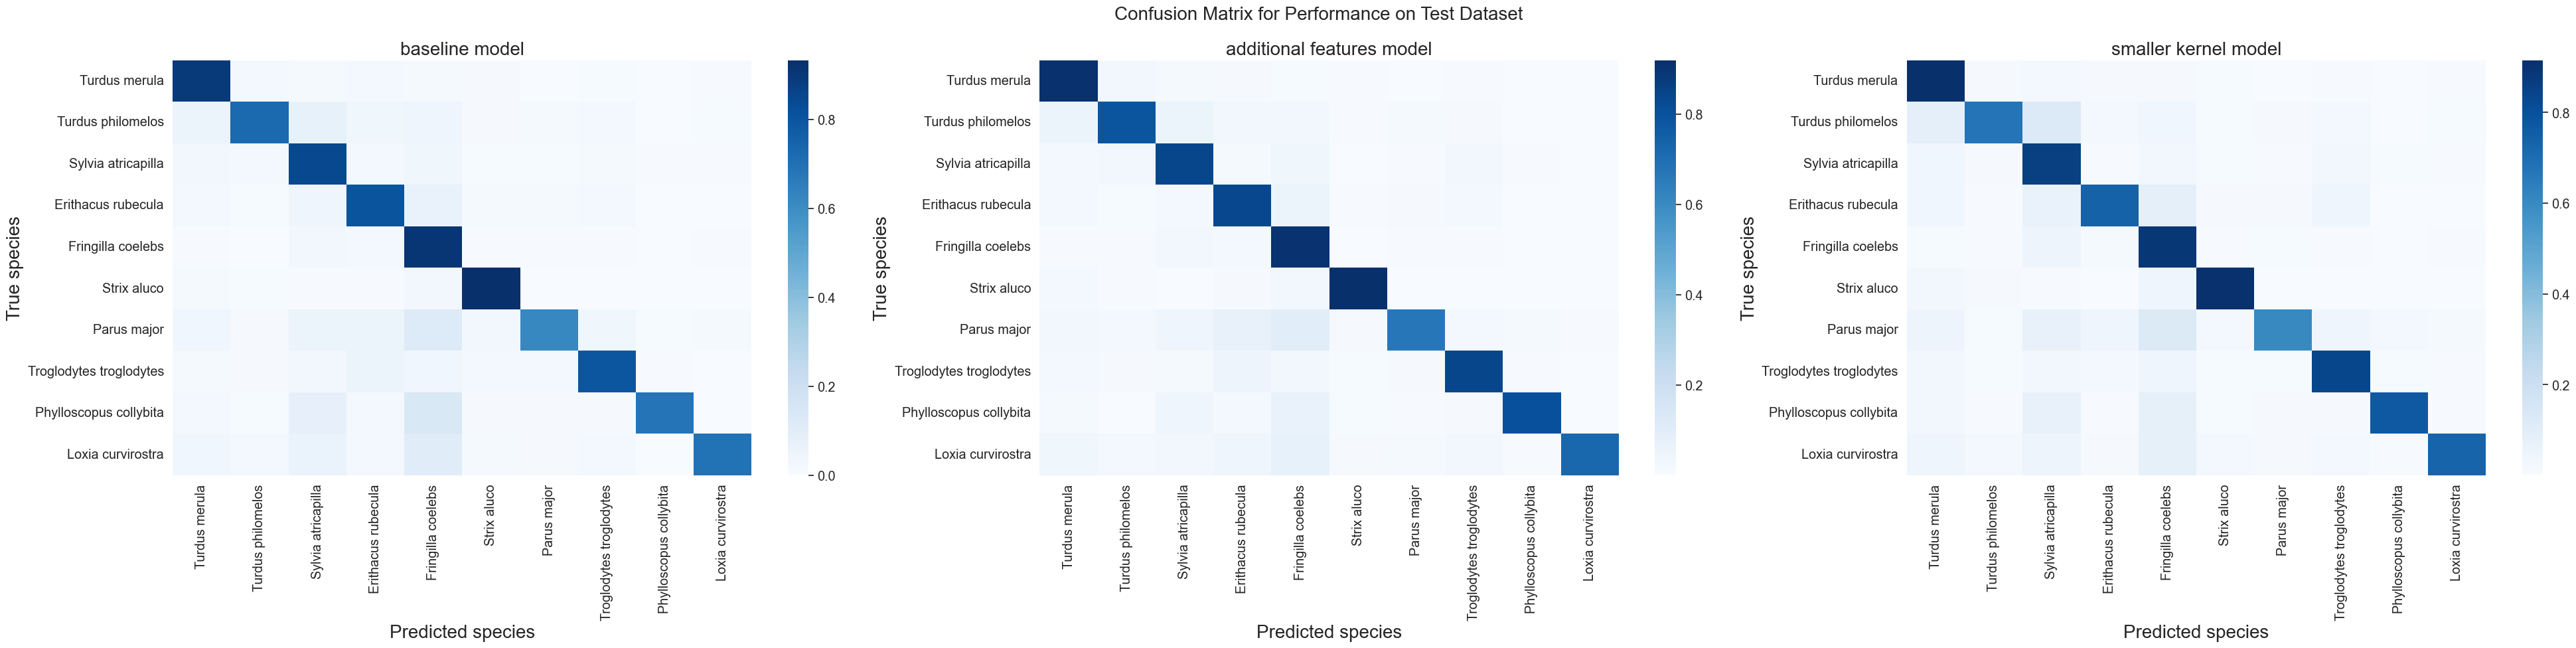

In [235]:
# Make all heatmaps
sns.set(font_scale = 1.3)
fig, axs = plt.subplots(1, 3, figsize=(40, 10)) #3,1, figsize=(8, 24))
fig.suptitle("Confusion Matrix for Performance on Test Dataset", size=20)
# baseline model
sns.heatmap(confusion_matrix(true_classes_test, pred_classes_test, normalize='true'), 
            yticklabels=list(birdnames.keys()),
            xticklabels=list(birdnames.keys()), cmap='Blues', ax = axs[0])
axs[0].set_title("baseline model", size=20)
axs[0].set_xlabel("Predicted species", size=20)
axs[0].set_ylabel("True species", size=20);

# additional information model
sns.heatmap(confusion_matrix(true_classes_test, pred_classes_add_test, normalize='true'),           
            yticklabels=list(birdnames.keys()),
           xticklabels=list(birdnames.keys()) , cmap='Blues', ax = axs[1])
axs[1].set_title("additional features model", size=20)
axs[1].set_xlabel("Predicted species", size=20)
axs[1].set_ylabel("True species", size=20);

# small kernel model
sns.heatmap(confusion_matrix(true_classes_test, pred_classes_sm_test, normalize='true'),
           yticklabels=list(birdnames.keys()),
            xticklabels=list(birdnames.keys()), cmap='Blues')
plt.title("smaller kernel model", size=20)
plt.xlabel("Predicted species", size=20)
plt.ylabel("True species", size=20);
plt.tight_layout(h_pad=3.5)

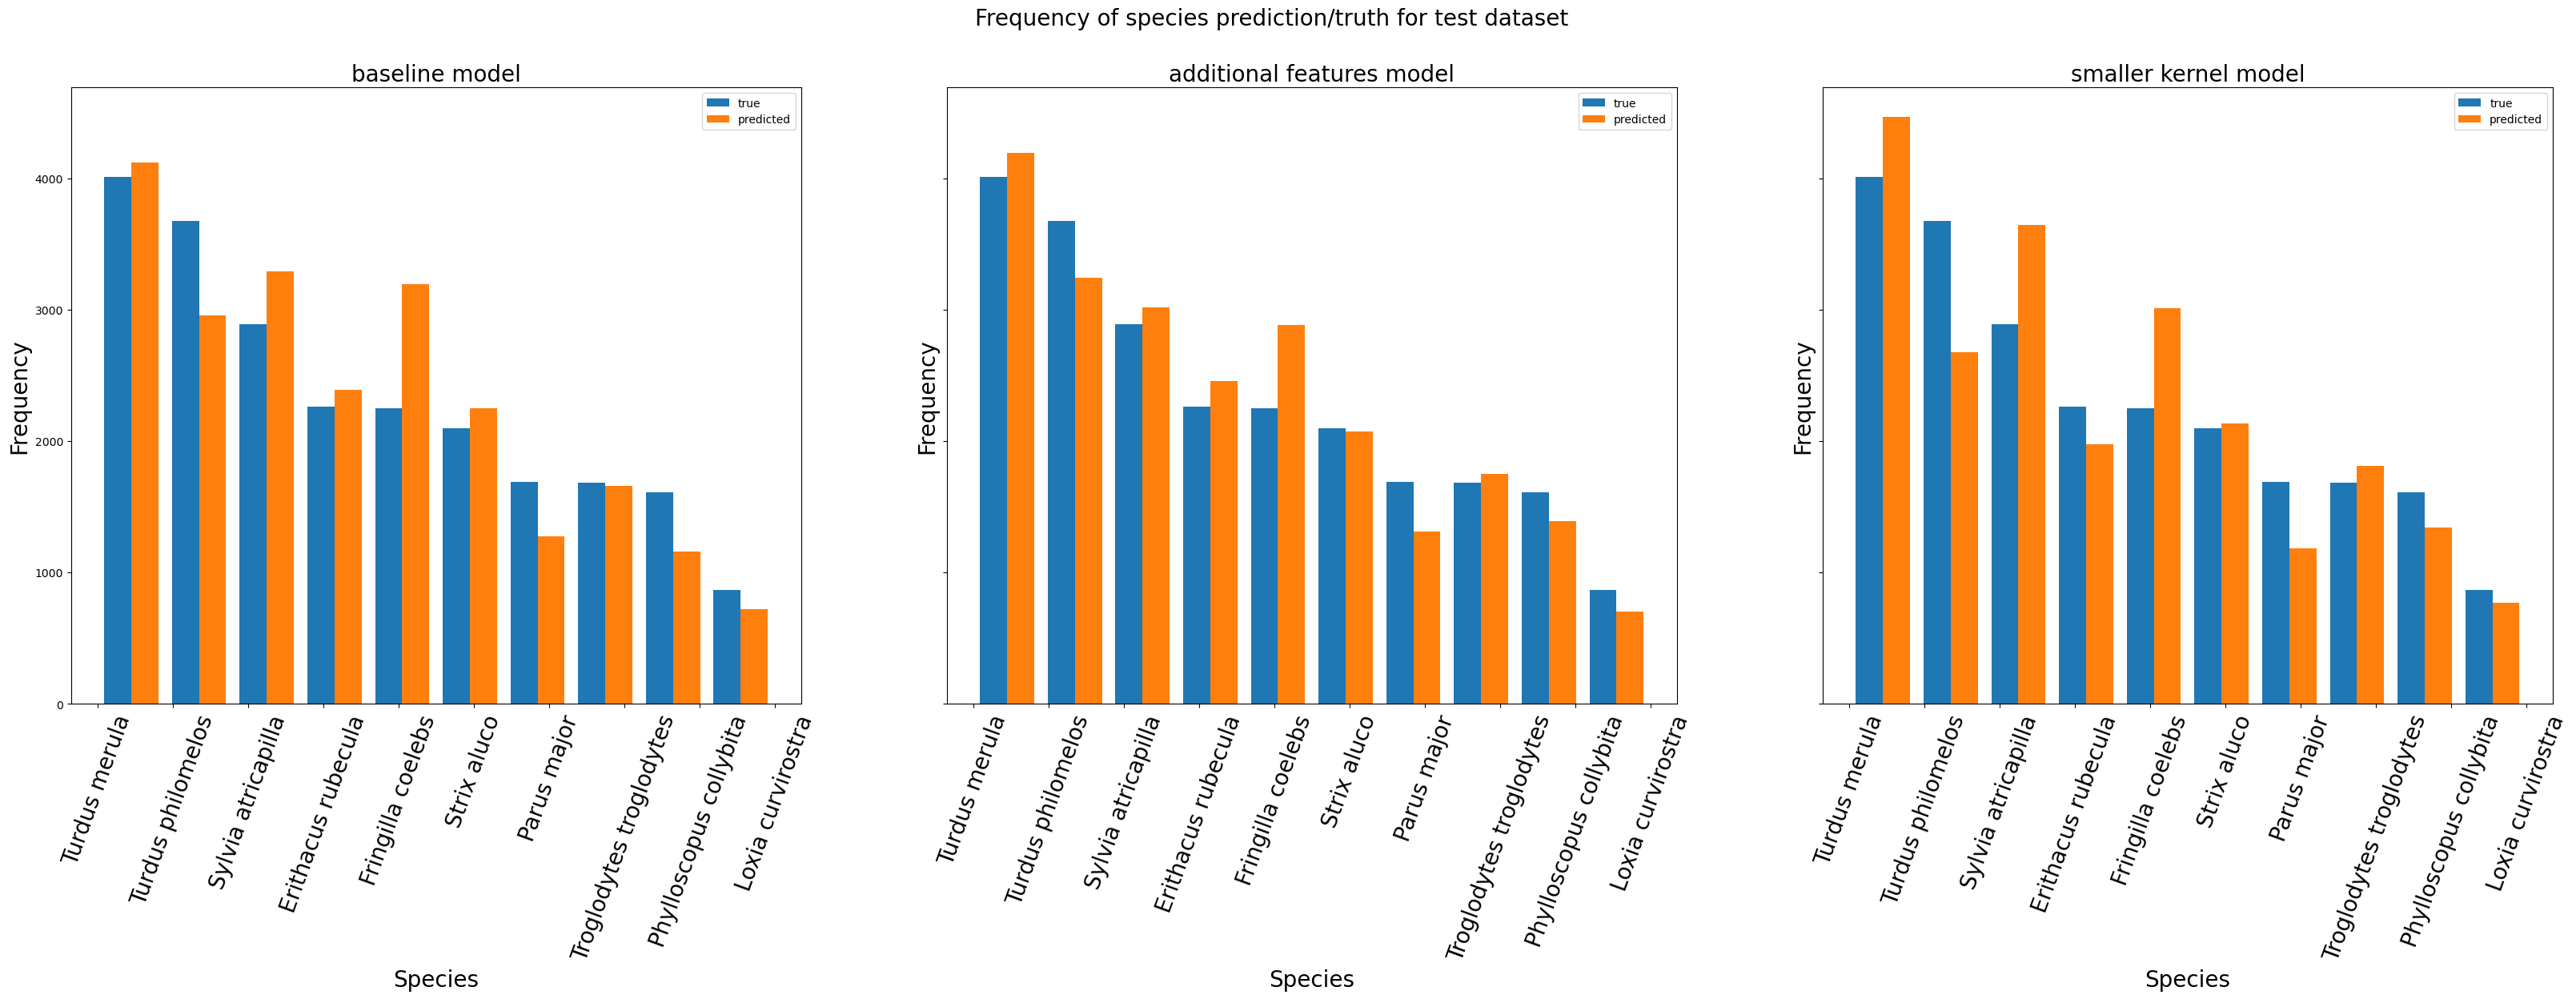

In [221]:
# Make all class histogram plots
fig, axs = plt.subplots(1, 3, figsize=(40, 10), sharey=True) #3,1, figsize=(8, 24))
fig.suptitle("Frequency of species prediction/truth for test dataset", size=20)
# baseline model
class_df = pd.DataFrame(columns=['true', 'predicted'])
class_df['true'] = true_classes_test
class_df['predicted'] = pred_classes_test

axs[0].hist(class_df, label=['true', 'predicted'])
axs[0].legend()
axs[0].set_xticks(ticks = np.arange(0,10), rotation=70, labels=list(birdnames.keys()), size=20);
axs[0].set_xlabel('Species', size=20)
axs[0].set_ylabel('Frequency', size=20)
axs[0].set_title("baseline model", size=20)

# additional features model
add_df = pd.DataFrame(columns=['true', 'predicted'])
add_df['true'] = true_classes_test
add_df['predicted'] = pred_classes_add_test

axs[1].hist(add_df, label=['true', 'predicted'])
axs[1].legend()
axs[1].set_xticks(ticks = np.arange(0,10), rotation=70, labels=list(birdnames.keys()), size=20);
axs[1].set_xlabel('Species', size=20)
axs[1].set_ylabel('Frequency', size=20)
axs[1].set_title("additional features model", size=20)

# small kernel model
sm_df = pd.DataFrame(columns=['true', 'predicted'])
sm_df['true'] = true_classes_test
sm_df['predicted'] = pred_classes_sm_test

axs[2].hist(sm_df, label=['true', 'predicted'])
axs[2].legend()
axs[2].set_xticks(ticks = np.arange(0,10), rotation=70, labels=list(birdnames.keys()), size=20);
axs[2].set_xlabel('Species', size=20)
axs[2].set_ylabel('Frequency', size=20)
axs[2].set_title("smaller kernel model", size=20);